# Homework 6 (more of a tutorial, really)

As I was browsing through Kaggle the other day, I came upon a brand new dataset from the University of Puerto Rico, which contains images of bees entering their hive.  The task is to determine automatically which bees are carrying pollen.  Your job will be to develop a convolutional neural network that performs this task.  

## 1. Load Data (0 pts)

First, we need to load the bee data, which is included along with this homework.  Fortunately, the authors of the Kaggle dataset provided a nice set of files which will do this for us, which I have reproduced below

In [1]:
import glob, os 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
path="images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

In [3]:
def dataset(file_list,size=(300,180),flattened=False):
    data = []
    for i, file in enumerate(file_list):
        image = io.imread(file)
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()

        data.append(image)

    labels = [1 if f.split("/")[-1][0] == 'P' else 0 for f in file_list]

    return np.array(data), np.array(labels)

In [4]:
# Load the dataset (may take a few seconds)
X,y=dataset(imlist)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [5]:
# X has the following structure: X[imageid, y,x,channel]
print('X: ',X.shape)  # data
print('y: ',y.shape)  # target

print('Class 0: ',sum(y==0))
print('Class 1: ',sum(y==1))
print('Total  : ',len(y))

X:  (714, 300, 180, 3)
y:  (714,)
Class 0:  345
Class 1:  369
Total  :  714


We can plot a couple of the images below.  If you check out a couple of these, you will see that the visible difference when bees carry pollen is the presence of large fluffy balls of pollen on their back legs.

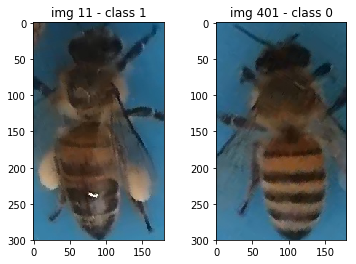

In [6]:
fig, axes = plt.subplots(1,2)
k=11
plt.sca(axes[0])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]))

k=401
plt.sca(axes[1])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]));

## 2. A convolutional network architecture for bee classification (40 pts)

**Implement a 2D convolutional neural network using Keras.  You are free to choose whatever network architecture you like.**

You can find all the relevant syntax for implementing such a network [here](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py), the Keras convnet example for MNIST.

*(For the sake of comparison, I will share the one that I used:*

Layer 1: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 2: 4x4 Max-pooling layer

Layer 3: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 4: 4x4 Max-pooling layer

Layer 5: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 6: 4x4 Max-pooling layer

Layer 7: Flattening layer

Layer 8: Dropout layer with 0.2 dropout probability

Layer 9: 1 node sigmoid layer


In [7]:
import keras
import keras.models as km
import keras.layers as kl
import numpy as np

input_shape = ((300,180,3))

model = km.Sequential()

#5x5 convolution layer with 24 kernels
model.add(kl.Conv2D(24,kernel_size=(5,5),
                    activation='relu',
                    input_shape=input_shape))

#4x4 max-pooling layer
model.add(kl.MaxPooling2D(pool_size=(4, 4)))

#5x5 convolution layer with 24 kernels
model.add(kl.Conv2D(24, (5, 5), activation='relu'))

#4x4 Max-pooling layer
model.add(kl.MaxPooling2D(pool_size=(4, 4)))

#5x5 convolution layer with 24 kernels
model.add(kl.Conv2D(24, (5, 5), activation='relu'))

#4x4 Max-pooling layer
model.add(kl.MaxPooling2D(pool_size=(4, 4)))

#Flattening layer
model.add(kl.Flatten())

#Dropout layer with 0.2 dropout probability
model.add(kl.Dropout(0.2))

#1 node sigmoid layer
model.add(kl.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


## 3. Fitting the CNN to data (20 pts)

Compile your model, using a binary crossentropy loss function and an optimizer of your choosing (RMSprop worked well for me).  Select a batch size and number of epochs, and fit your model to the training data, while also keeping track of the test set accuracy.

**Plot the training and test accuracy of your model at each epoch.  Comment on whether you think the model is being overfit.**

Train on 571 samples, validate on 143 samples
Epoch 1/50
571/571 [==============================] - 21s 36ms/step - loss: 0.6609 - acc: 0.5814 - val_loss: 0.6450 - val_acc: 0.6434
Epoch 2/50
571/571 [==============================] - 20s 35ms/step - loss: 0.5764 - acc: 0.7145 - val_loss: 0.6255 - val_acc: 0.6294
Epoch 3/50
571/571 [==============================] - 21s 36ms/step - loss: 0.5026 - acc: 0.7741 - val_loss: 0.5443 - val_acc: 0.7483
Epoch 4/50
571/571 [==============================] - 21s 37ms/step - loss: 0.4229 - acc: 0.8196 - val_loss: 0.5803 - val_acc: 0.6643
Epoch 5/50
571/571 [==============================] - 21s 37ms/step - loss: 0.3975 - acc: 0.8179 - val_loss: 0.3466 - val_acc: 0.8392
Epoch 6/50
571/571 [==============================] - 24s 43ms/step - loss: 0.3533 - acc: 0.8511 - val_loss: 0.3199 - val_acc: 0.8392
Epoch 7/50
571/571 [==============================] - 25s 44ms/step - loss: 0.3250 - acc: 0.8669 - val_loss: 0.2935 - val_acc: 0.8881
Epoch 8/50
571/5

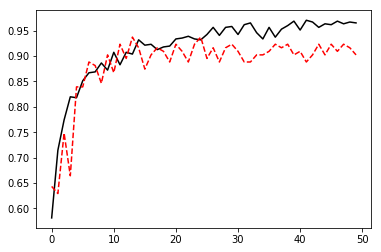

In [8]:
model.compile(loss=keras.losses.binary_crossentropy,        #! Specify a loss function
              optimizer=keras.optimizers.RMSprop(),         #! Specify an optimizer
              metrics=['accuracy'])

batch_size = 16                       #! Specify a batch size
epochs = 50                            #! Specify an epoch  
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test,y_test))

#! Plot test and training accuracy (note that the history.history object is a dictionary containing relevant info)
f = history.history
plt.plot(f['acc'],'k-')
plt.plot(f['val_acc'],'r--')
plt.show()

In [11]:
print("The model appears to start displaying signs of being overfit around epoch 20 - the test accuracy stalls and doesn't really continue to show improvement, while the training accuracy continues to slowly pull up.")

The model appears to start displaying signs of being overfit around epoch 20 - the test accuracy stalls and doesn't really continue to show improvement, while the training accuracy continues to slowly pull up.


## 4. Model evaluation (20 pts)

Now that you have a trained model, make a prediction for the test set (model.predict is a useful function for this).  **Compute and display a confusion matrix.  Select and display an example from the test set of a true positive, a true negative, a false positive, and a false negative.  Speculate on the reasons behind misclassification for images that your model predicted incorrectly**.

Confusion Matrix:
[[59  7]
 [ 7 70]]
Classification Accuracy
90.20979020979021 %
71
105
43
78


Text(0.5,1,'False Negative')

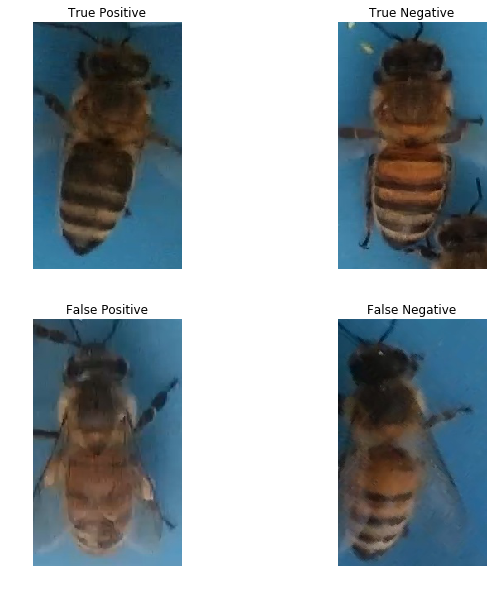

In [39]:
from sklearn.metrics import confusion_matrix
import random
from random import randrange

prediction = model.predict(X_test)

preds = []
for i in prediction:
    if i > 0.5:
        preds.append(1)
    else:
        preds.append(0)

print("Confusion Matrix:")
cm = confusion_matrix(preds,y_test)
print(cm)
print ("Classification Accuracy")
accuracy = ((cm[0,0] + cm[1,1])/cm.sum()) * 100
print(accuracy, "%")

truepos = []
trueneg = []
falsepos = []
falseneg = []

for i in range(1, len(preds)):
    if preds[i] == 1 and y_test[i] == 1:
        truepos.append(i)
        
    if preds[i] == 0 and y_test[i] == 0:
        trueneg.append(i)
        
    if preds[i] == 1 and y_test[i] == 0:
        falsepos.append(i)
        
    if preds[i] == 0 and y_test[i] == 1:
        falseneg.append(i)
        
tpexample = randrange(len(truepos))
tnexample = randrange(len(trueneg))
fpexample = randrange(len(falsepos))
fnexample = randrange(len(falseneg))
print(random.choice(truepos))
print(random.choice(trueneg))
print(random.choice(falsepos))
print(random.choice(falseneg))

fig, axes = plt.subplots(2,2, figsize = (10,10))

#true positive
plt.sca(axes[0,0])
plt.imshow(X_test[tpexample])
plt.axis('off')
plt.title("True Positive")

#true negative
plt.sca(axes[0,1])
plt.imshow(X_test[tnexample])
plt.axis('off')
plt.title("True Negative")

#false positive
plt.sca(axes[1,0])
plt.imshow(X_test[fpexample])
plt.axis('off')
plt.title("False Positive")

#false negative
plt.sca(axes[1,1])
plt.imshow(X_test[fnexample])
plt.axis('off')
plt.title("False Negative")

False classifications - both negative and positive - seem to be due to the picture being cut off in some way, generally cutting off parts of the leg which are obviously important to see. Several of the false positives also have coloring near the leg (on the wing?) that even look like pollen to me!  